In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(caret)
install.packages("e1071")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘testthat’

The following object is masked from ‘package:dplyr’:

    matches

The following object is masked from ‘package:purrr’:

    is_null

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


Reading the data into R using read.csv with a comma delimiter. 

In [2]:
red_data <- read.csv("winequality-red.csv", sep = ";") 
head(red_data)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


The data is already tidy, so there is no need to do anything to it.

Partitioning the data into training and testing sets. 

In [5]:
set.seed(100)

training_set <- red_data %>% 
    select(quality) %>% 
    unlist() %>% 
    createDataPartition(p = 0.75, list = FALSE)

X_train <- red_data %>% 
    select(-density, -quality) %>% 
    slice(training_set) %>% 
    data.frame()

Y_train <- red_data %>% 
    select(quality) %>% 
    slice(training_set) %>% 
    unlist()

X_test <- red_data %>% 
    select(-density, -quality) %>% 
    slice(-training_set) %>% 
    data.frame()

Y_test <- red_data %>% 
    select(quality) %>% 
    slice(-training_set) %>% 
    unlist()

Selecting the best value of k to use.

In [6]:
train_control <- trainControl(method = "cv", number = 10)
k = data.frame(k = seq(from = 1, to = 100, by = 1))

knn <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = k, trControl = train_control)
knn

k-Nearest Neighbors 

1200 samples
  10 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1080, 1080, 1080, 1079, 1080, 1080, ... 
Resampling results across tuning parameters:

  k    RMSE       Rsquared    MAE      
    1  0.8622696  0.17627422  0.5333063
    2  0.7869634  0.17569629  0.5595983
    3  0.7713734  0.16383159  0.5710962
    4  0.7648516  0.15536581  0.5796962
    5  0.7515361  0.16144076  0.5778731
    6  0.7474851  0.16131368  0.5793297
    7  0.7471562  0.15843604  0.5798052
    8  0.7487238  0.15262095  0.5818425
    9  0.7457168  0.15364922  0.5774423
   10  0.7448809  0.15168333  0.5797007
   11  0.7420889  0.15596624  0.5790597
   12  0.7406330  0.15845307  0.5793459
   13  0.7425765  0.15331659  0.5813389
   14  0.7403749  0.15687714  0.5781765
   15  0.7419765  0.15311638  0.5792016
   16  0.7428998  0.15032830  0.5810589
   17  0.7421178  0.15260770  0.5810477
   18  0.7406806  0.15536631  0.5812315
   19  0.7416701  0.

The plot of k vs RMSE

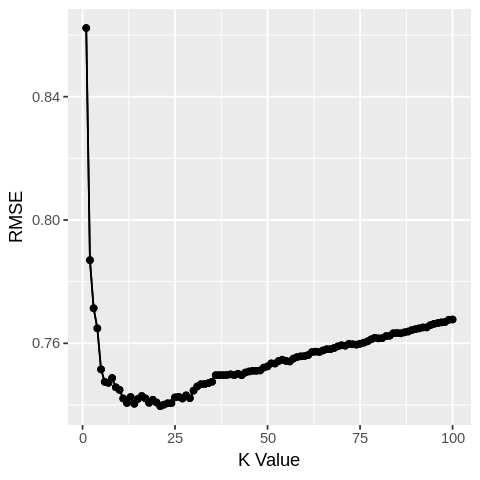

In [8]:
options(repr.plot.width = 4, repr.plot.height = 4)

k_accuracies <- knn$results

RMSE_plot <- knn %>% 
    ggplot(aes(x = k, y = RMSE)) + 
    geom_point() +
    geom_line() +
    xlab("K Value") + 
    ylab("RMSE")

RMSE_plot

We will select k = 21 to train our model because k is the smallest k value that give the smallest RMSE.

In [90]:
k_best <- data.frame(k = 7)
knn_red <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = k_best)
knn_red

k-Nearest Neighbors 

1200 samples
  10 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1200, 1200, 1200, 1200, 1200, 1200, ... 
Resampling results:

  RMSE     Rsquared   MAE      
  0.78228  0.1191443  0.6005299

Tuning parameter 'k' was held constant at a value of 7

Testing the model onto the test data.

In [11]:
k <- data.frame(k = 21)
knn_21 <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = k)

test <- predict(knn_21, X_test)

predictions <- data.frame(obs = Y_test, pred = test)

head(predictions, n = 10)

,obs,pred
quality1,5,5.476190
quality2,5,5.428571
quality3,5,5.363636
quality4,5,5.428571
quality5,5,5.523810
quality6,7,5.285714
quality7,4,5.476190
quality8,5,5.476190
quality9,5,5.333333
quality10,6,5.590909


In [12]:
test_error <- defaultSummary(predictions)
test_error

RMSE  Rsquared       MAE 
0.7500920 0.1735361 0.5864421

The min and max wine qualities in the testing set. 

In [14]:
min(Y_test)
max(Y_test)

error_ratio <- 0.750092009457794/(8-3)
error_ratio

[1] 3

[1] 8

[1] 0.1500184

Let's try to reduce this error. 

In [15]:
red_data_new <- red_data %>% 
    mutate(acidity.ratio = volatile.acidity/fixed.acidity) %>% 
    mutate(sulfur.dioxide.ratio = free.sulfur.dioxide/total.sulfur.dioxide) %>% 
    mutate(alcohol.percent = alcohol / 100) %>%
    select(residual.sugar, chlorides, pH, sulphates, acidity.ratio, sulfur.dioxide.ratio, alcohol.percent, quality)

red_scaled <- red_data_new %>% 
  select(-quality) %>% 
  scale(center = FALSE) 

red_scaled <- data.frame(quality = red_data_new$quality, red_scaled)


head(red_scaled)

quality,residual.sugar,chlorides,pH,sulphates,acidity.ratio,sulfur.dioxide.ratio,alcohol.percent
5,0.6541052,0.7649761,1.0585855,0.8237400,1.2983699,0.7841759,0.8968984
5,0.8950914,0.9864165,0.9650922,1.0002557,1.5485320,0.9044091,0.9350642
5,0.7918116,0.9260236,0.9831877,0.9561268,1.3373685,0.6732824,0.9350642
6,0.6541052,0.7549106,0.9530286,0.8531593,0.3431406,0.6867480,0.9350642
5,0.6541052,0.7649761,1.0585855,0.8237400,1.2983699,0.7841759,0.8968984
5,0.6196787,0.7549106,1.0585855,0.8237400,1.2241773,0.7877404,0.8968984


In [16]:
scaled_training <- red_scaled %>% 
    select(quality) %>% 
    unlist() %>% 
    createDataPartition(p = 0.75, list = FALSE)

X_train_scaled <- red_scaled %>% 
    select(-quality) %>% 
    slice(scaled_training) %>% 
    data.frame()

Y_train_scaled <- red_scaled %>% 
    select(quality) %>% 
    slice(scaled_training) %>% 
    unlist()

X_test_scaled <- red_scaled %>% 
    select(-quality) %>% 
    slice(-scaled_training) %>% 
    data.frame()

Y_test_scaled <- red_scaled %>% 
    select(quality) %>% 
    slice(-scaled_training) %>% 
    unlist()


In [17]:
train_control <- trainControl(method = "cv", number = 10)
k = data.frame(k = seq(from = 1, to = 100, by = 1))

knn_scaled <- train(x = X_train_scaled, y = Y_train_scaled, method = "knn", tuneGrid = k, trControl = train_control)
knn_scaled

k-Nearest Neighbors 

1200 samples
   7 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1080, 1080, 1080, 1080, 1080, 1079, ... 
Resampling results across tuning parameters:

  k    RMSE       Rsquared   MAE      
    1  0.7816862  0.2767084  0.4582365
    2  0.7414771  0.2681052  0.5216998
    3  0.7245404  0.2648313  0.5293627
    4  0.7109858  0.2666888  0.5297685
    5  0.7119799  0.2541996  0.5369366
    6  0.7011559  0.2662887  0.5321627
    7  0.7046043  0.2582094  0.5409280
    8  0.7011626  0.2590453  0.5401962
    9  0.6988850  0.2609281  0.5403839
   10  0.6969819  0.2634710  0.5397774
   11  0.6919621  0.2720553  0.5367005
   12  0.6888503  0.2779782  0.5345136
   13  0.6879204  0.2800307  0.5346607
   14  0.6870292  0.2813755  0.5356328
   15  0.6903895  0.2747170  0.5394909
   16  0.6902599  0.2751704  0.5404713
   17  0.6874199  0.2812519  0.5387491
   18  0.6872942  0.2814943  0.5392699
   19  0.6873961  0.2814611  0.5395941


In [100]:
k_best_scaled = data.frame(k = 26)

knn_scaled <- train(x = X_train_scaled, y = Y_train_scaled, method = "knn", tuneGrid = k_best_scaled)

knn_scaled


k-Nearest Neighbors 

1200 samples
   7 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1200, 1200, 1200, 1200, 1200, 1200, ... 
Resampling results:

  RMSE       Rsquared  MAE      
  0.6975325  0.27102   0.5524058

Tuning parameter 'k' was held constant at a value of 26

,obs,pred
quality1,5,5.000000
quality2,5,5.692308
quality3,5,5.576923
quality4,5,5.461538
quality5,4,5.269231
quality6,6,5.461538
quality7,6,5.576923
quality8,5,5.111111
quality9,5,5.153846
quality10,6,5.785714


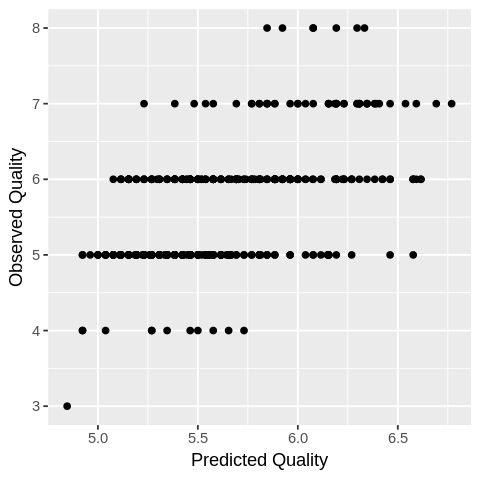

In [19]:
k <- data.frame(k = 26)

knn_final_s <- train(x = X_train_scaled, y = Y_train_scaled, method = "knn", tuneGrid = k)

test_scaled <- predict(knn_final_s, X_test_scaled)

predictions_scaled <- data.frame(obs = Y_test_scaled, pred = test_scaled)

head(predictions_scaled, n = 10)

plot <- predictions_scaled %>% 
    ggplot(aes(x = pred, y = obs)) +
    geom_point() + 
    xlab("Predicted Quality") + 
    ylab("Observed Quality")

plot

In [21]:
test_error <- defaultSummary(predictions_scaled)
test_error

error_ratio <- 0.671133163073198/(8-3)
error_ratio

RMSE  Rsquared       MAE 
0.6711332 0.2943847 0.5352627

[1] 0.1342266